In [2]:
import pandas as pd
import numpy as np

!pip install fastai -Uqq
!pip install ipyplot -Uqq

from fastai.data.all import *
from fastai.vision.all import *
from PIL import Image
import plotly.express as px
import os

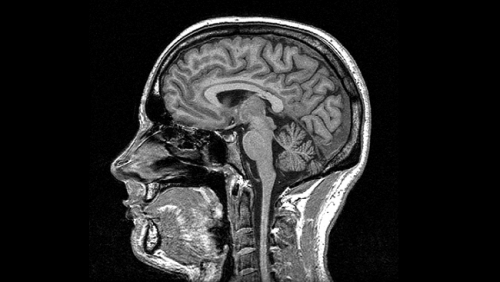

# Background
Magnetic resonance imaging (MRI) is a medical imaging technique that uses a strong magnetic field and radio waves to produce detailed images of the body's internal structures. Because it can produce precise images of the brain's soft tissue, it is frequently employed in the diagnosis of brain cancers.

Machine learning techniques can analyse vast volumes of imaging data and spot patterns that may be challenging for human experts to see. To improve the precision and effectiveness of methods for diagnosing brain tumours, researchers are now finding ways to train machine learning models on vast datasets of MRI scans.

## Note:
This project will utilise the highly efficient deep learning package *fastai*  (https://github.com/fastai/fastai) which is built on top of the *PyTorch* library, as I am currently studying deep learning using the *fast.ai* course and would like to supplement my learning through the building of a project.

# Preparing the Data
### Loading into a DataFrame, for convenience

In [3]:
# Load dataset
data_dir1 = 'Datasets/brain_tumor_dataset'
data_dir2 = 'Datasets/brain_tumor_dataset2'

# Check the labels for each MRI photo, between each dataset
print(os.listdir(f'{data_dir1}'))
print(os.listdir(f'{data_dir2}'))

# Create dictionary to map label to unified label
labeller = {'yes': 'Tumour', 'Brain Tumor': 'Tumour', 'no': 'No Tumour', 'Healthy': 'No Tumour'}

# Merge the two datasets and change labels between datasets using parent_label from fastai
df = pd.DataFrame({'image':(*get_image_files(data_dir1), *get_image_files(data_dir2))})
df['label'] = df.apply(lambda x: labeller[parent_label(x.image)], 'columns')
df['size'] = df.apply(lambda x: Image.open(x.image).size, 'columns')

df.head()

['no', 'yes']
['Brain Tumor', 'Healthy']


,image,label,size
0,Datasets\brain_tumor_dataset\no\1 no.jpeg,No Tumour,"(630, 630)"
1,Datasets\brain_tumor_dataset\no\10 no.jpg,No Tumour,"(173, 201)"
2,Datasets\brain_tumor_dataset\no\11 no.jpg,No Tumour,"(300, 168)"
3,Datasets\brain_tumor_dataset\no\12 no.jpg,No Tumour,"(275, 183)"
4,Datasets\brain_tumor_dataset\no\13 no.jpg,No Tumour,"(300, 168)"


We have two separate datasets containing MRI images that have been classified as having a brain tumour (yes/Brain Tumour folder) or not (no/Healthy folder), which we have merged together and unified labels so that they are either labelled 'Tumour' or 'No Tumour'. This merged dataset will form the full dataset used to train and validate the deep learning model. The image size has also been outputted as we would like to standardise this.

### How many images do we have for each diagnosis?

In [3]:
df.value_counts('label')

label
Tumour       2823
No Tumour    2283
dtype: int64

The dataset doesn't contain an equal number of images for each diagnosis.

### What's the variation in image sizes?
We require the images to be of the same size because this means the images will collate well with the tensors of the model when trained upon.

In [4]:
w, h = list(zip(*df['size'].values)) # Unzip list into width and height using zip() and *

sizesdata = pd.DataFrame({'width':w, 'height':h, 'label':df['label'].values})

fig = px.scatter(sizesdata, x = w, y = h, color = 'label', labels={'x':'Width', 'y':'Height', 'label':'Diagnosis'}, height = 550, width = 700, title = 'Distribution of Image Width and Height', marginal_x = 'histogram', marginal_y = 'histogram')
fig.show()

To utilise *fastai* for image classification, we first need to build a *DataBlock*, which is an object containing the structure of the inputs and labels that we feed into the deep learning algorithm. A *DataBlock* requires us to specify how large we want the training and validation sets to be. We'll also indicate that we want to perform data augmentation by resizing the images to the same size (400, 400) using the 'squish' method. After the *DataBlock* is defined, we can feed our pandas DataFrame into a *DataLoaders* object which acts as a data-filled input in the structure of our *DataBlock*.

In [5]:
dblock = DataBlock.from_columns(blocks = (ImageBlock, CategoryBlock),
    get_items = lambda x: (x.image, x.label), # Our input is the image path and the label is already in the dataset, so we output these (this acts like the .apply method)
    splitter = RandomSplitter(valid_pct=0.2, seed=42), # We set aside 20% of the dataset to be the validation set, the remaining 80% makes up the training set.
    item_tfms = Resize(400, method = 'squish'),
    batch_tfms = [Normalize.from_stats(*imagenet_stats)])

dloaders = dblock.dataloaders(df) # Feed df into a dataloaders following the structure of the DataBlock defined above

It should also be noted that we have applied a normalization transform to the images.

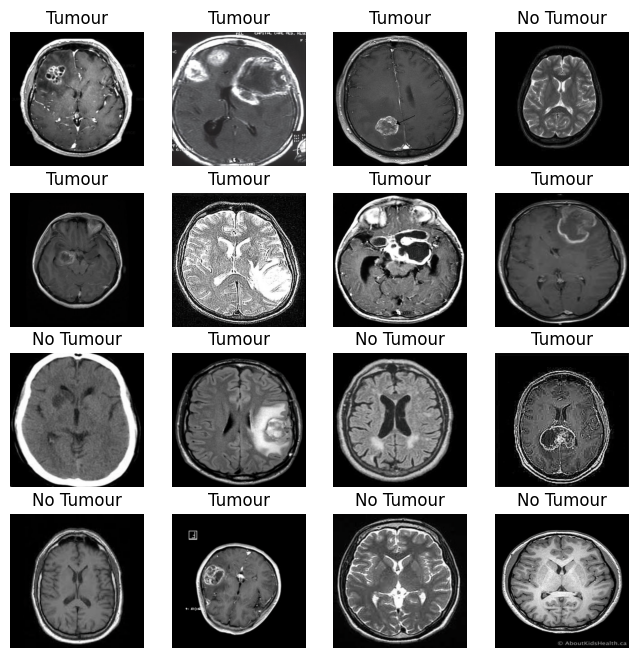

In [6]:
dloaders.valid.show_batch(max_n = 16, nrows = 4, figsize=(8,8)) # Show batches of dataset

# Model
### Training the Model using a CNN
We're first going to train a model using a Convolutional Neural Network and the resnet18 architecture, which is a pre-trained CNN model that is 18 layers deep. This will allow us to quickly reach an impresive accuracy rate as we don't need to spend copious amounts of time training a deep learning model from scratch.

In [7]:
model = vision_learner(dloaders, resnet18, loss_func=CrossEntropyLossFlat(), metrics = accuracy) # Utilise a Convolutional Neural Network approach
model.fine_tune(3) # Tune the model, using 3 epochs

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.517932,0.207580,0.940255,00:41


epoch,train_loss,valid_loss,accuracy,time
0,0.148901,0.128568,0.963761,00:39
1,0.069587,0.063749,0.985309,00:39
2,0.025725,0.061450,0.985309,00:39


So we've managed to train a CNN model **capable of diagnosing brain tumours from MRIs with a 98.5% accuracy rate**. 

### Possible approaches to attempt to improve accuracy:
1. Utilise a different network architecture to resnet18, maybe using resnet34 as it is a deeper model.
2. Make changes to the data augmentation: Adjust the batch transformation method, or use a different method of resizing.
3. Raise the number of epochs.

# Model Evaluation

              precision    recall  f1-score   support

   No Tumour       0.99      0.98      0.98       462
      Tumour       0.98      0.99      0.99       559

    accuracy                           0.99      1021
   macro avg       0.99      0.98      0.99      1021
weighted avg       0.99      0.99      0.99      1021



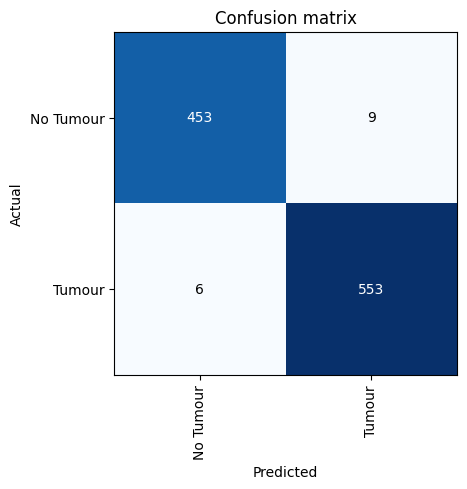

In [8]:
# Output the confusion matrix to check where the errors occur
conf = ClassificationInterpretation.from_learner(model)
conf.print_classification_report()
conf.plot_confusion_matrix()

The confusion matrix shows that we only have **9 false positives** and **6 false negatives**.

### Incorrect Predictions
Let's take a look at all of **the images that were classified incorrectly** below.

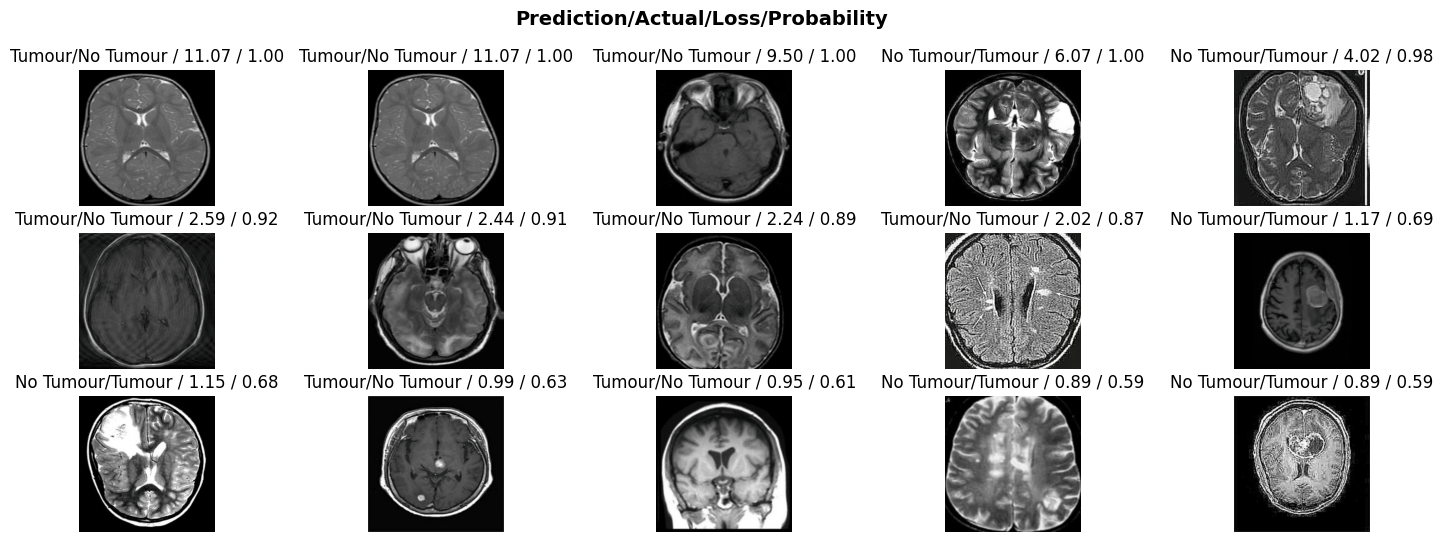

In [14]:
conf.plot_top_losses(k=15, figsize=(18,6)) # Plot the 15 incorrect predictions

### Some of the reasons for the inaccuracy here could be explained by:
Some of the MRI images in our dataset appear to require cropping, as we'd like to minimise the dark space around the image. This is the opposite for some other images seen above, which appear to have already been cropped and thus we are losing information. If the model were to be used on new inputs, we ask that the MRI image be cropped just enough so that the skull takes up the whole image.

Can we reach a greater level of accuracy by utilising a different architecture or loss function?

**WIP**